In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
os.environ["MUJOCO_GL"] = "egl"

In [3]:
import dm_control.suite.common as common
from dm_control import mujoco
from dm_control import viewer
from PIL import Image

libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card8: Permission denied

libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card7: Permission denied

libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card6: Permission denied

libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card5: Permission denied

libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card4: Permission denied

libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card3: Permission denied

libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card2: Permission denied

libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card1: Permission denied

/data/user_data/fcpei/miniconda3/envs/fish/lib/python3.12/site-packages/

In [4]:
from zfa_rl_agent.core.environments.grating import create_grating_texture, swimmer_grating_venv
from zfa_rl_agent.core.environments.zebrafish import swimmer_venv
create_grating_texture()
import numpy as np
import matplotlib.pyplot as plt

/data/user_data/fcpei/miniconda3/envs/fish/lib/python3.12/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/data/user_data/fcpei/miniconda3/envs/fish/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-10 10:03:08,403	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [5]:
from zfa_rl_agent.core.agent.PPO.rPPO import PPO
from zfa_rl_agent.core.agent.curiosity.wrapper import CuriosityWrapper

In [6]:
model_path = '/data/user_data/fcpei/zfa_checkpoints/grating-progress-mlp-idm-1.0-task-0.0-penalty-1.0-swimmer-false-2025-04-05_18-44-18-4513401_13195776_steps.zip'

env = swimmer_grating_venv(parallel=0, 
                   use_ray=0, 
                   n_envs=1, 
                   seed=12345, 
                   monitor_dir=None, 
                   view_render_args=dict(height=480, width=640),
                   grating_speed=0.01)#base_env = swimmer()

model = PPO.load(model_path, env)

2025-04-10 10:04:03,925 - zfa_rl_agent.core.utils.logger - INFO - Vectorizing with DummyVecEnv
INFO:zfa_rl_agent.core.utils.logger:Vectorizing with DummyVecEnv
/data/user_data/fcpei/miniconda3/envs/fish/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:165: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  deserialized_object = cloudpickle.loads(base64_object)
/data/user_data/fcpei/miniconda3/envs/fish/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:165: DeprecationWarning: numpy

345


In [7]:
deterministic = False

obs = env.reset()
frames = [env.render()]
eye_view = [obs.get("pixels")]

done = False
actions = []
while not done:
    action, _ = model.predict(obs, deterministic=deterministic)

    obs, reward, done, info = env.step(action)
 
    actions.append(action)
    frames.append(env.render())
    eye_view.append(obs.get("pixels"))

In [8]:
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
clip = ImageSequenceClip(frames, fps=1 / 0.03)
clip.write_videofile(os.path.expanduser("temp_video_gratings.mp4"))

clip = ImageSequenceClip(eye_view, fps=1 / 0.03)
clip.write_videofile(os.path.expanduser("temp_video_gratings_eye.mp4"))

MoviePy - Building video temp_video_gratings.mp4.
MoviePy - Writing video temp_video_gratings.mp4



MoviePy - Done !
MoviePy - video ready temp_video_gratings.mp4
MoviePy - Building video temp_video_gratings_eye.mp4.
MoviePy - Writing video temp_video_gratings_eye.mp4



MoviePy - Done !
MoviePy - video ready temp_video_gratings_eye.mp4


In [8]:
actions = np.stack(actions, axis=0).squeeze()
actions.shape

(1000, 5)

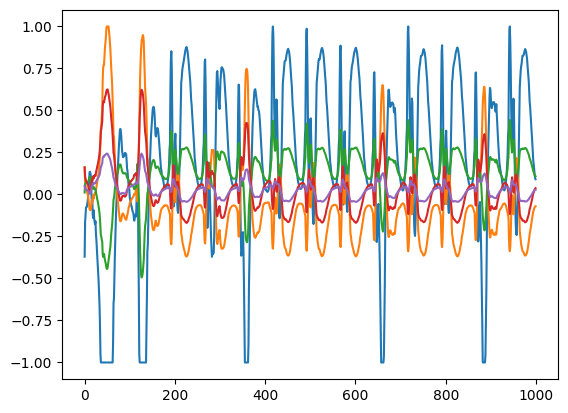

In [9]:
plt.plot(actions)

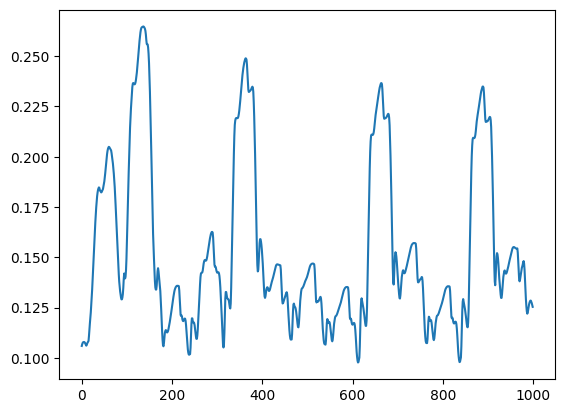

In [24]:
window_len = 50

normalization = np.apply_along_axis(
    lambda arr: np.convolve(arr, np.ones(window_len) / window_len, mode='same'),
    axis=0,
    arr=np.ones_like(actions),
)
sliding_mean = np.apply_along_axis(
    lambda arr: np.convolve(arr, np.ones(window_len) / window_len, mode='same'),
    axis=0,
    arr=actions,
) / normalization
sliding_std = np.apply_along_axis(
    lambda arr: np.convolve(arr, np.ones(window_len) / window_len, mode='same'),
    axis=0,
    arr=np.square(actions - sliding_mean),
) / normalization

sliding_std = np.sqrt(sliding_std)

plt.plot(sliding_std.mean(axis=-1))

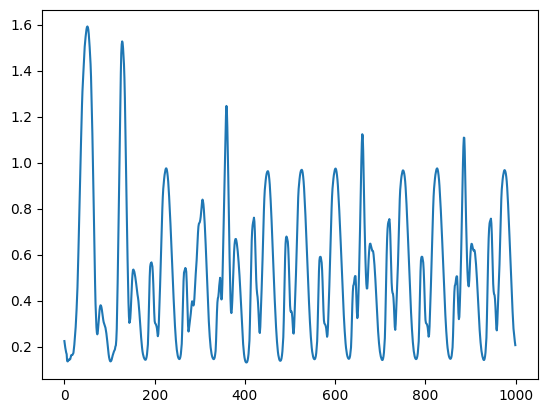

In [21]:
window_len = 10

action_norm = np.linalg.norm(actions, axis=-1, keepdims=True)

normalization = np.apply_along_axis(
    lambda arr: np.convolve(arr, np.ones(window_len) / window_len, mode='same'),
    axis=0,
    arr=np.ones_like(action_norm),
)
sliding_mean = np.apply_along_axis(
    lambda arr: np.convolve(arr, np.ones(window_len) / window_len, mode='same'),
    axis=0,
    arr=action_norm,
) / normalization

plt.plot(sliding_mean)

In [23]:
active = sliding_std.mean(axis=-1) > 0.17
state_starts = np.nonzero(np.diff(active.astype(int), prepend=(1 - active[0])) != 0)[0]
state_ends = np.nonzero(np.diff(active.astype(int), append=(1 - active[-1])) != 0)[0] + 1

(array([113., 255., 272.,  97.,  23.,  36.,  47.,  73.,  56.,  28.]),
 array([0.09765959, 0.11437188, 0.13108417, 0.14779647, 0.16450876,
        0.18122105, 0.19793334, 0.21464563, 0.23135793, 0.24807022,
        0.26478251]),
 <BarContainer object of 10 artists>)

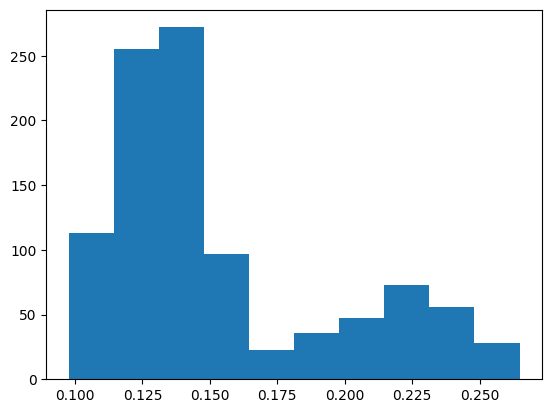

In [26]:
plt.hist(sliding_std.mean(axis=-1))

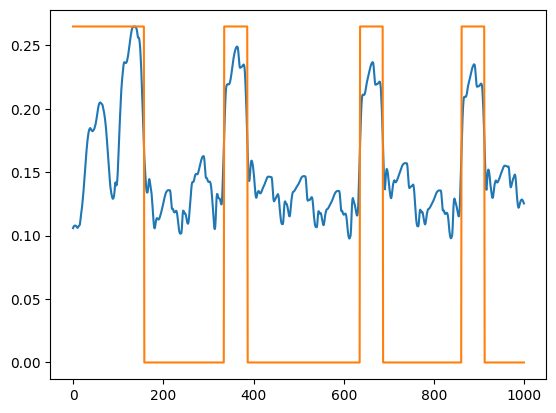

In [25]:
threshold = 0.17  # eyeballed
min_passive_duration = 1 / 0.03  # 1 sec min duration

active = sliding_std.mean(axis=-1) > threshold
state_starts = np.nonzero(np.diff(active.astype(int), prepend=(1 - active[0])) != 0)[0]
state_ends = np.nonzero(np.diff(active.astype(int), append=(1 - active[-1])) != 0)[0] + 1
state_durations = state_ends - state_starts
state_types = active[state_starts]
passive_drops = (state_durations < min_passive_duration) & (state_types == 0)
for start, end in zip(state_starts[passive_drops], state_ends[passive_drops]):
    active[start:end] = 1

plt.plot(sliding_std.mean(axis=-1))
plt.plot(active * sliding_std.mean(axis=-1).max())

In [28]:
state_switches = np.nonzero(np.diff(active.astype(int), prepend=int(active[0])) != 0)[0]
active_to_passive_switches = np.nonzero(np.diff(active.astype(int), prepend=int(active[0])) < 0)[0]

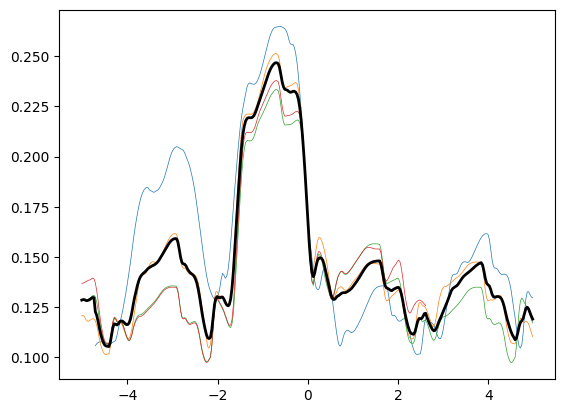

In [49]:
window = (int(round(-5 / 0.03)), int(round(5 / 0.03)))

all_window_data = []
for switch_idx in active_to_passive_switches:
    start = max(0, int(round(switch_idx + window[0])))
    start_clip_amount = max(0, -int(round(switch_idx + window[0])))
    end = min(len(active), int(round(switch_idx + window[1])))
    end_clip_amount = max(0, int(round(switch_idx + window[1])) - len(active))
    window_data = sliding_std.mean(axis=-1)[start:end]
    if start_clip_amount > 0:
        window_data = np.concatenate([
            np.full((start_clip_amount,), np.nan),
            window_data,
        ])
    if end_clip_amount > 0:
        window_data = np.concatenate([
            window_data,
            np.full((end_clip_amount,), np.nan),
        ])
    plt.plot(
        np.arange(window[0], window[1]) * 0.03,
        window_data,
        linewidth=0.5,
    )
    all_window_data.append(window_data)
all_window_mean = np.nanmean(all_window_data, axis=0)
plt.plot(np.arange(window[0], window[1]) * 0.03, all_window_mean, color='black', linewidth=2)

In [27]:
def compute_sliding_std(actions, window_len=50):
    normalization = np.apply_along_axis(
        lambda arr: np.convolve(arr, np.ones(window_len) / window_len, mode='same'),
        axis=0,
        arr=np.ones_like(actions),
    )
    sliding_mean = np.apply_along_axis(
        lambda arr: np.convolve(arr, np.ones(window_len) / window_len, mode='same'),
        axis=0,
        arr=actions,
    ) / normalization
    sliding_std = np.apply_along_axis(
        lambda arr: np.convolve(arr, np.ones(window_len) / window_len, mode='same'),
        axis=0,
        arr=np.square(actions - sliding_mean),
    ) / normalization

    sliding_std = np.sqrt(sliding_std)
    return sliding_std.mean(axis=-1)

In [28]:
def compute_activity_state(sliding_std, threshold=0.17, min_passive_duration=int(round(1 / 0.03))):
    active = sliding_std > threshold
    state_starts = np.nonzero(np.diff(active.astype(int), prepend=(1 - active[0])) != 0)[0]
    state_ends = np.nonzero(np.diff(active.astype(int), append=(1 - active[-1])) != 0)[0] + 1
    state_durations = state_ends - state_starts
    state_types = active[state_starts]
    passive_drops = (state_durations < min_passive_duration) & (state_types == 0)
    for start, end in zip(state_starts[passive_drops], state_ends[passive_drops]):
        active[start:end] = 1
    return active

In [29]:
def extract_transitions(active, sliding_std, window=(-167, 167)):
    active_to_passive_switches = np.nonzero(np.diff(active.astype(int), prepend=int(active[0])) < 0)[0]
    all_window_data = []
    for switch_idx in active_to_passive_switches:
        start = max(0, int(round(switch_idx + window[0])))
        start_clip_amount = max(0, -int(round(switch_idx + window[0])))
        end = min(len(active), int(round(switch_idx + window[1])))
        end_clip_amount = max(0, int(round(switch_idx + window[1])) - len(active))
        if (end_clip_amount + start_clip_amount) > 0.4 * (window[1] - window[0]):
            continue
        window_data = sliding_std[start:end]
        if start_clip_amount > 0:
            window_data = np.concatenate([
                np.full((start_clip_amount,), np.nan),
                window_data,
            ])
        if end_clip_amount > 0:
            window_data = np.concatenate([
                window_data,
                np.full((end_clip_amount,), np.nan),
            ])
        all_window_data.append(window_data)
    all_window_data = np.stack(all_window_data, axis=0)
    return all_window_data

In [30]:
def sample_episode(model, env, deterministic=False):
    obs = env.reset()
    done = False
    actions = []
    while not done:
        action, _ = model.predict(obs, deterministic=deterministic)
        obs, reward, done, info = env.step(action)
        actions.append(action)
    return np.stack(actions, axis=0).squeeze()

In [31]:
n_episodes = 5

deterministic = False
window_len = 50
threshold = 0.17
min_passive_duration = int(round(1 / 0.03))
window = (-167, 167)

all_agent_swim_signals = []
for _ in range(n_episodes):
    actions = sample_episode(model, env, deterministic=deterministic)
    sliding_std = compute_sliding_std(actions, window_len=window_len)
    active = compute_activity_state(sliding_std, threshold=threshold, min_passive_duration=min_passive_duration)
    all_agent_swim_signals.append(
        extract_transitions(active, sliding_std, window=window)
    )
all_agent_swim_signals = np.concatenate(all_agent_swim_signals, axis=0)
all_agent_swim_signals_mean = np.nanmean(all_agent_swim_signals, axis=0)
all_agent_timestamps = np.arange(window[0], window[1]) * 0.03

In [32]:
from pathlib import Path

import pynwb

import pandas as pd

In [33]:
DATA_ROOT = Path("/data/group_data/neuroagents_lab/legacy_neural_datasets/zfa_data/000350")
NWB_FILES = sorted(DATA_ROOT.glob("*/*.nwb"))

io_objs = [pynwb.NWBHDF5IO(str(f), mode='r') for f in NWB_FILES]
nwbfiles = [io.read() for io in io_objs]

/data/user_data/fcpei/miniconda3/envs/fish/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/data/user_data/fcpei/miniconda3/envs/fish/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/data/user_data/fcpei/miniconda3/envs/fish/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [34]:
threshold = 5

all_activity_states = []
for idx, nwbfile in enumerate(nwbfiles):
    # get swim intervals
    swim_intervals = nwbfile.processing["behavior"].data_interfaces["SwimIntervals"].to_dataframe()
    # compute inter-swim intervals and find when it exceeds threshold
    last_stop = np.concatenate([np.zeros(1), swim_intervals.stop_time.to_numpy()])
    exp_len = nwbfile.processing["behavior"].data_interfaces["FilteredSwimSignals"].data.shape[0] / nwbfile.processing["behavior"].data_interfaces["FilteredSwimSignals"].rate
    exp_len += nwbfile.processing["behavior"].data_interfaces["FilteredSwimSignals"].starting_time
    curr_start = np.concatenate([swim_intervals.start_time.to_numpy(), np.array([exp_len])])
    isi = curr_start - last_stop
    passive = (isi > 5)
    passive_start = last_stop[passive]
    passive_end = curr_start[passive]
    assert len(passive_start) == len(passive_end)
    # build dataframe with active/passive intervals
    activity_state_intervals = []
    if passive_start[0] != 0.0:
        activity_state_intervals.append(dict(start_time=0.0, stop_time=passive_start[0], state_type="active"))
    for i in range(len(passive_start)):
        activity_state_intervals.append(
            dict(start_time=passive_start[i], stop_time=passive_end[i], state_type="passive"))
        if i + 1 < len(passive_start):
            activity_state_intervals.append(
                dict(start_time=passive_end[i], stop_time=passive_start[i + 1], state_type="active"))
    if passive_end[-1] < exp_len:
        activity_state_intervals.append(
            dict(start_time=passive_end[-1], stop_time=exp_len, state_type="active"))
    activity_state_intervals = pd.DataFrame(activity_state_intervals)
    # compare with their pre-defined activity states
    # first make a time series of our activity states
    timestamps = np.arange(nwbfile.processing["behavior"].data_interfaces["FilteredSwimSignals"].data.shape[0]) / (nwbfile.processing["behavior"].data_interfaces["FilteredSwimSignals"].rate)
    timestamps += nwbfile.processing["behavior"].data_interfaces["FilteredSwimSignals"].starting_time
    timestamps = timestamps[::100]
    our_state = np.zeros_like(timestamps)
    for start, end in zip(passive_start, passive_end):
        our_state[(timestamps >= start) & (timestamps <= end)] = 1
    # then make a time series of their activity states
    nwb_state = np.full_like(timestamps, np.nan)
    for i, state in nwbfile.processing["behavior"].data_interfaces["ActivityStates"].to_dataframe().iterrows():
        if state["state_type"] in ["active", "passive"]:
            nwb_state[(timestamps >= state["start_time"]) & (timestamps <= state["stop_time"])] = 0 if state["state_type"] == "active" else 1
    # compare the two
    mask = ~np.isnan(nwb_state)
    correct_percent = np.sum(our_state[mask] == nwb_state[mask]) / np.sum(mask)
    print(f"{idx}: {correct_percent}")
    # store the results
    all_activity_states.append(activity_state_intervals)

0: 0.9945897204688909
1: 0.9956954117504222
2: 0.9925280199252802
3: 0.9967567567567568
4: 0.9973631524976806
5: 0.9955668405160581
6: 0.9743860269678545
7: 0.9967065913599128
8: 0.9948758549405116
9: 0.949422675347009
10: 0.9954374437374491
11: 0.9683458622148459


In [35]:
# all transitions

window = (-10, 10)  # seconds
downsample_factor = 100
enforce_full_window = True

all_fish_swim_signals = []

for idx, activity_states in enumerate(all_activity_states):
    mask = (
        (activity_states.state_type.to_numpy()[1:] == "passive") & 
        (activity_states.state_type.to_numpy()[:-1] == "active")
    )
    if enforce_full_window:
        mask = (
            mask &
            (activity_states.stop_time.to_numpy()[1:] - activity_states.start_time.to_numpy()[1:] >= window[1]) &
            (activity_states.stop_time.to_numpy()[:-1] - activity_states.start_time.to_numpy()[:-1] >= -window[0])
        )
    mask = np.concatenate([[False], mask])
    transition_times = activity_states.start_time.to_numpy()[mask]

    swim_signal = nwbfiles[idx].processing["behavior"].data_interfaces["FilteredSwimSignals"].data[::downsample_factor]
    timestamps = np.arange(len(swim_signal)) / (nwbfiles[idx].processing["behavior"].data_interfaces["FilteredSwimSignals"].rate / downsample_factor)
    timestamps += nwbfiles[idx].processing["behavior"].data_interfaces["FilteredSwimSignals"].starting_time

    window_len = int((window[1] - window[0]) * nwbfiles[idx].processing["behavior"].data_interfaces["FilteredSwimSignals"].rate / downsample_factor)
    transition_swim_signals = np.full(
        (
            len(transition_times), 
            window_len,
            2
        ),
        np.nan,
    )

    for i, tt in enumerate(transition_times):
        start_idx = np.argmin(np.abs(timestamps - (tt + window[0])))  # find closest timestamp
        end_idx = start_idx + window_len
        if end_idx >= len(swim_signal):
            continue
        transition_swim_signals[i, :, :] = swim_signal[start_idx:end_idx, :]
    
    all_fish_swim_signals.append(transition_swim_signals)
    

In [36]:
all_fish_swim_signals_mean = [
    arr.mean(axis=-1) for arr in all_fish_swim_signals
]

# assume all files have same sample rate
sample_rate = nwbfiles[0].processing["behavior"].data_interfaces["FilteredSwimSignals"].rate / downsample_factor
all_fish_timestamps = np.arange(
    window[0] * sample_rate,
    window[0] * sample_rate + all_fish_swim_signals[0].shape[1],
) / sample_rate

In [37]:
from scipy import signal
from scipy.stats import pearsonr

def smooth(x, width, axis=0):
    if width == 0:
        return x
    kernel = signal.windows.gaussian(width * 6, std=width, sym=True)
    kernel /= np.sum(kernel)
    def padded_convolve(arr, kernel):
        if len(kernel) % 2 == 0:
            pad_width = (len(kernel) // 2, len(kernel) // 2 - 1)
        else:
            pad_width = len(kernel) // 2
        arr = np.pad(arr, pad_width, mode='edge')
        return np.convolve(arr, kernel, mode='valid')
    return np.apply_along_axis(lambda y: padded_convolve(y, kernel), axis=axis, arr=x)

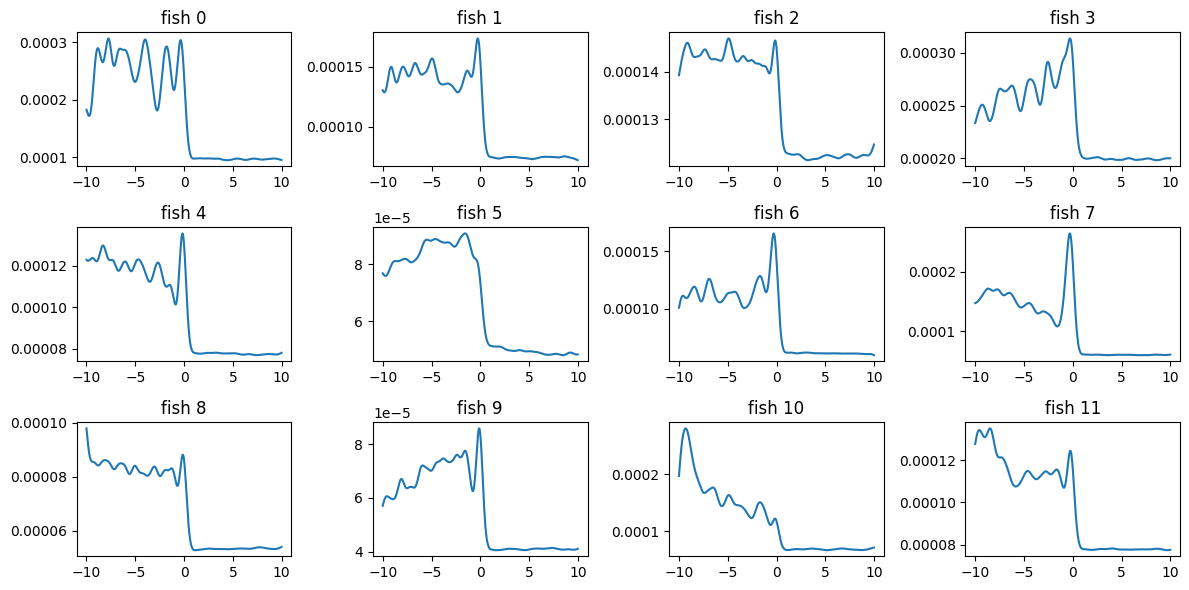

In [38]:
fig, axs = plt.subplots(3, 4, figsize=(12, 6))
for i in range(12):
    ax = axs[i // 4, i % 4]
    vals = smooth(np.mean(all_fish_swim_signals_mean[i], axis=0), width=20)
    ax.plot(np.linspace(window[0], window[1], len(vals) + 1)[:-1], vals)
    ax.set_title(f"fish {i}")
plt.tight_layout()

In [39]:
inter_fish_corrs = []
for i in range(len(all_fish_swim_signals_mean) - 1):
    for j in range(i+1, len(all_fish_swim_signals_mean)):
        fish1 = all_fish_swim_signals_mean[i]
        fish2 = all_fish_swim_signals_mean[j]
        fish1 = smooth(np.mean(fish1, axis=0), width=20)
        fish2 = smooth(np.mean(fish2, axis=0), width=20)
        corr = pearsonr(fish1, fish2)[0]
        inter_fish_corrs.append(corr)

In [58]:
time_ratios = [1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]
agent_fish_corrs = dict()

for tr in time_ratios:
    agent_fish_corrs[tr] = []

    rescaled_agent_timestamps = all_agent_timestamps * tr
    window_start = max(rescaled_agent_timestamps[0], all_fish_timestamps[0])
    window_end = min(rescaled_agent_timestamps[-1], all_fish_timestamps[-1])

    agent_mask = (rescaled_agent_timestamps >= window_start) & (rescaled_agent_timestamps <= window_end)
    fish_mask = (all_fish_timestamps >= window_start) & (all_fish_timestamps <= window_end)
    agent_timestamps = rescaled_agent_timestamps[agent_mask]
    fish_timestamps = all_fish_timestamps[fish_mask]

    agent_data = all_agent_swim_signals_mean[agent_mask]
    agent_data = np.interp(fish_timestamps, agent_timestamps, agent_data)

    for i in range(len(all_fish_swim_signals_mean)):
        fish_data = np.mean(all_fish_swim_signals_mean[i], axis=0)[fish_mask]
        fish_data = smooth(fish_data, width=20)
        corr = pearsonr(agent_data, fish_data)[0]
        agent_fish_corrs[tr].append(corr)

Text(0, 0.5, 'pearson $r$')

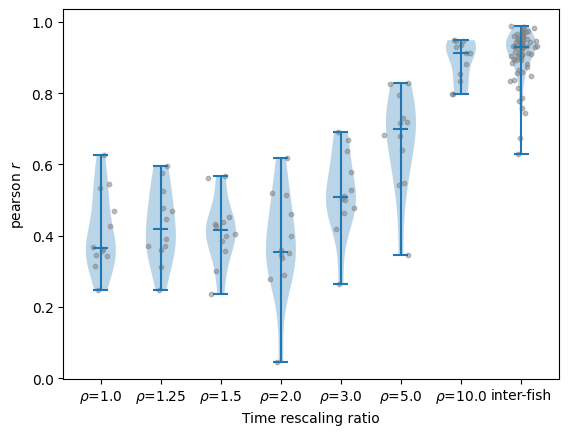

In [59]:
plt.violinplot(
    [np.array(agent_fish_corrs[tr]) for tr in time_ratios] + [np.array(inter_fish_corrs)],
    showmedians=True,
)
for i, tr in enumerate(time_ratios):
    plt.scatter(
        np.random.randn(len(agent_fish_corrs[tr])) * 0.1 + (i + 1), 
        agent_fish_corrs[tr], alpha=0.5, s=10, color="gray",
    )
plt.scatter(
    np.random.randn(len(inter_fish_corrs)) * 0.1 + (len(time_ratios) + 1), 
    inter_fish_corrs, alpha=0.5, s=10, color="gray"
)
plt.xticks(
    np.arange(1, len(time_ratios) + 2), 
    [r"$\rho$=" + f"{tr}" for tr in time_ratios] + ["inter-fish"],
)
plt.xlabel("Time rescaling ratio")
plt.ylabel(r"pearson $r$")

In [65]:
# random agent: gaussian process

length_scale = 200
var = 0.3 ** 2

pos = np.arange(1000)
dist = np.square(pos[:, None] - pos[None, :])
cov = np.exp(-dist / length_scale) * var

rng = np.random.default_rng(0)
random_actions = rng.multivariate_normal(np.zeros(1000), cov, size=(5,)).T

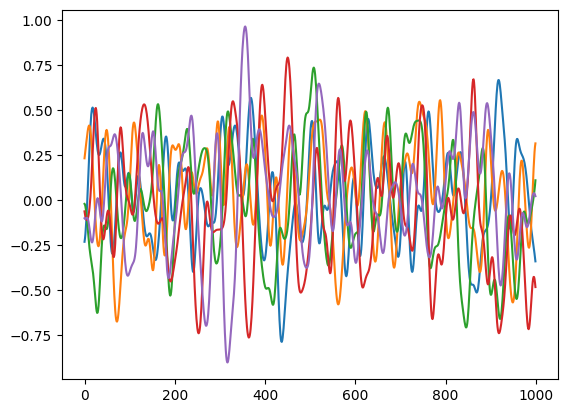

In [66]:
plt.plot(random_actions)

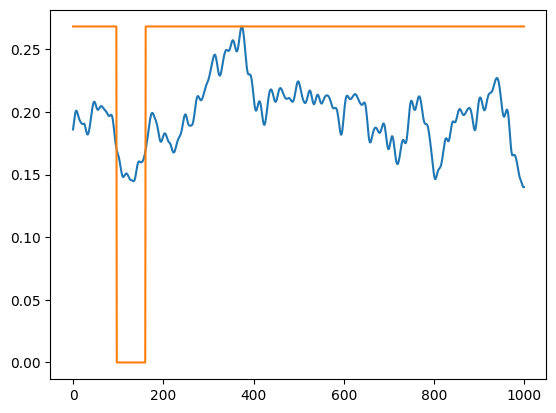

In [68]:
sliding_std = compute_sliding_std(random_actions)
active = compute_activity_state(sliding_std)
plt.plot(sliding_std)
plt.plot(active * sliding_std.max())

In [69]:
deterministic = False
window_len = 50
threshold = 0.17
min_passive_duration = int(round(1 / 0.03))
window = (-167, 167)

length_scale = 200
var = 0.3 ** 2

pos = np.arange(1000)
dist = np.square(pos[:, None] - pos[None, :])
cov = np.exp(-dist / length_scale) * var

all_random_swim_signals = []
for _ in range(n_episodes):
    actions = rng.multivariate_normal(np.zeros(1000), cov, size=(5,)).T
    sliding_std = compute_sliding_std(actions, window_len=window_len)
    active = compute_activity_state(sliding_std, threshold=threshold, min_passive_duration=min_passive_duration)
    all_random_swim_signals.append(
        extract_transitions(active, sliding_std, window=window)
    )
all_random_swim_signals = np.concatenate(all_random_swim_signals, axis=0)
all_random_swim_signals_mean = np.nanmean(all_random_swim_signals, axis=0)
all_random_timestamps = np.arange(window[0], window[1]) * 0.03

In [84]:
time_ratios = [1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]
random_fish_corrs = dict()

for tr in time_ratios:
    random_fish_corrs[tr] = []

    rescaled_random_timestamps = all_random_timestamps * tr
    window_start = max(rescaled_random_timestamps[0], all_fish_timestamps[0])
    window_end = min(rescaled_random_timestamps[-1], all_fish_timestamps[-1])

    random_mask = (rescaled_random_timestamps >= window_start) & (rescaled_random_timestamps <= window_end)
    fish_mask = (all_fish_timestamps >= window_start) & (all_fish_timestamps <= window_end)
    random_timestamps = rescaled_random_timestamps[random_mask]
    fish_timestamps = all_fish_timestamps[fish_mask]

    random_data = all_random_swim_signals_mean[random_mask]
    random_data = np.interp(fish_timestamps, random_timestamps, random_data)

    for i in range(len(all_fish_swim_signals_mean)):
        fish_data = np.mean(all_fish_swim_signals_mean[i], axis=0)[fish_mask]
        fish_data = smooth(fish_data, width=20)
        corr = pearsonr(random_data, fish_data)[0]
        random_fish_corrs[tr].append(corr)

Text(0, 0.5, 'pearson $r$')

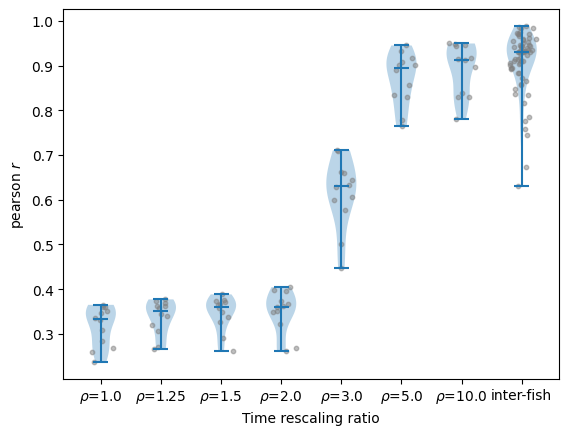

In [85]:
plt.violinplot(
    [np.array(random_fish_corrs[tr]) for tr in time_ratios] + [np.array(inter_fish_corrs)],
    showmedians=True,
)
for i, tr in enumerate(time_ratios):
    plt.scatter(
        np.random.randn(len(random_fish_corrs[tr])) * 0.1 + (i + 1), 
        random_fish_corrs[tr], alpha=0.5, s=10, color="gray",
    )
plt.scatter(
    np.random.randn(len(inter_fish_corrs)) * 0.1 + (len(time_ratios) + 1), 
    inter_fish_corrs, alpha=0.5, s=10, color="gray"
)
plt.xticks(
    np.arange(1, len(time_ratios) + 2), 
    [r"$\rho$=" + f"{tr}" for tr in time_ratios] + ["inter-fish"],
)
plt.xlabel("Time rescaling ratio")
plt.ylabel(r"pearson $r$")

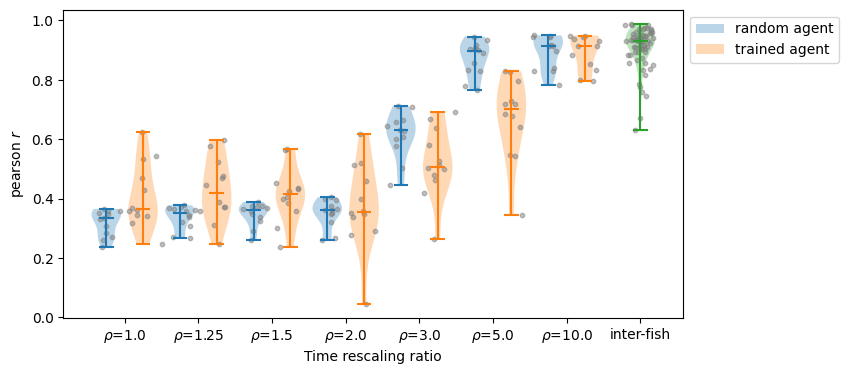

In [ ]:
fig = plt.figure(figsize=(8, 4))

random_vln = plt.violinplot(
    [np.array(random_fish_corrs[tr]) for tr in time_ratios],
    positions=np.arange(1, len(random_fish_corrs) + 1) - 0.25,
    widths=0.4,
    showmedians=True,
)
agent_vln = plt.violinplot(
    [np.array(agent_fish_corrs[tr]) for tr in time_ratios],
    positions=np.arange(1, len(agent_fish_corrs) + 1) + 0.25,
    widths=0.4,
    showmedians=True,
)
fish_vln = plt.violinplot(
    [inter_fish_corrs],
    positions=[len(agent_fish_corrs) + 1],
    widths=0.4,
    showmedians=True,
)
for i, tr in enumerate(time_ratios):
    plt.scatter(
        np.random.randn(len(random_fish_corrs[tr])) * 0.1 + (i + 1 - 0.25), 
        random_fish_corrs[tr], alpha=0.5, s=10, color="gray",
    )
    plt.scatter(
        np.random.randn(len(agent_fish_corrs[tr])) * 0.1 + (i + 1 + 0.25), 
        agent_fish_corrs[tr], alpha=0.5, s=10, color="gray",
    )
plt.scatter(
    np.random.randn(len(inter_fish_corrs)) * 0.1 + (len(time_ratios) + 1), 
    inter_fish_corrs, alpha=0.5, s=10, color="gray"
)
plt.xticks(
    np.arange(1, len(time_ratios) + 2), 
    [r"$\rho$=" + f"{tr}" for tr in time_ratios] + ["inter-fish"],
)
plt.xlabel("Time rescaling ratio")
plt.ylabel(r"pearson $r$")
plt.legend(
    [random_vln["bodies"][0], agent_vln["bodies"][0]],
    ["random agent", "trained agent"],
    loc="upper left",
    bbox_to_anchor=(1, 1),
)

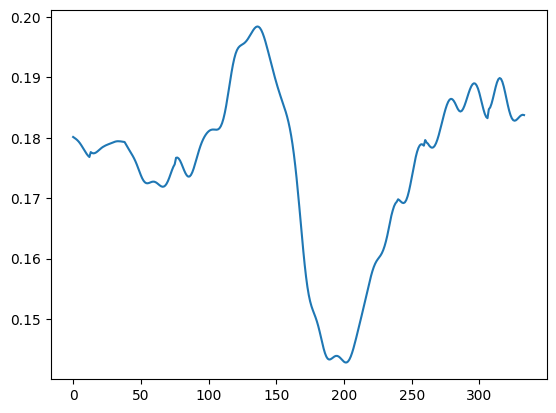

In [91]:
plt.plot(all_random_swim_signals_mean)